In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Trying out the data


In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import pickle as pkl
from sklearn.linear_model import Ridge
import sklearn.metrics
import math
import os
import matplotlib.pyplot as plt

In [3]:
response_data = pd.read_parquet("/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/response_data.parquet")
response_data = response_data.drop(columns = ['voxel_id'])
metadata = pd.read_csv("/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/metadata.csv")
stimulus_data = pd.read_csv("/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/stimulus_data.csv")

In [4]:
# Modify stimulus_data to contain the correct image path
folder_pth = "/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/training_imgs/stimulus_set/"
new_image_path = []

for i in range(950):
  new_image_path.append(folder_pth + stimulus_data["image_path"][i].split("/")[-1])

folder_pth = "/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/testing_imgs/stimulus_set/"
for i in range(950, 1000):
  new_image_path.append(folder_pth + stimulus_data["image_path"][i].split("/")[-1])

stimulus_data["image_path"] = new_image_path

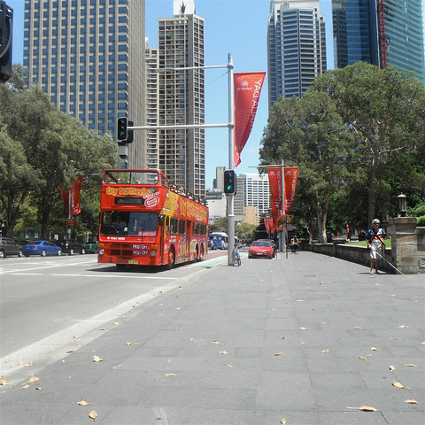

In [5]:
# To select an image
img_num = 953
img = Image.open(stimulus_data["image_path"][img_num])
img_name = stimulus_data["image_id"][img_num]
img

In [6]:
# To select voxel response for the image
voxels = response_data[img_name].to_numpy()

In [7]:
# To select the sentence description
sentence = stimulus_data["coco_categs"][img_num] #coco_captions

## Loading the github repositories

In [8]:
! git clone https://github.com/GusStgoReyes/CNS-GAN.git

Cloning into 'CNS-GAN'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 209 (delta 6), reused 18 (delta 6), pack-reused 186
Receiving objects: 100% (209/209), 2.08 MiB | 2.71 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [9]:
! pip3 install -r CNS-GAN/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 55.0 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
  Created wheel for visdom: filename=visdom-0.2.3-py3-none-any.whl size=1417107 sha256=4b90d1bd53698d0cd1a094a8a6057c7d1c244328c492136ca999e4cfa81f74b4
  Stored in directory: /root/.cache/pip/wheels/4d/73/32/0bbe55d2dccb9d80d3f020f474c15a5a1eef232817dcebe776
Successfully built visdom


In [10]:
! mkdir CNS-GAN/tmp
! mkdir CNS-GAN/tmp/feat_data

## Data loader

In [11]:
# Modify the script to have Resize instead of Scale

! python CNS-GAN/decode/train_dataloader.py --img_data "/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/training_imgs" --output CNS-GAN/tmp/feat_data

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100% 548M/548M [00:01<00:00, 400MB/s]
---------loading decode training data---------
---------decode training data saved---------


In [12]:
# Open the files just saved from the previous model
with open("/content/CNS-GAN/tmp/feat_data/images_vgg19_bn_fc.pickle", 'rb') as pickle_file:
    images = pkl.load(pickle_file)

with open("/content/CNS-GAN/tmp/feat_data/features_vgg19_bn_fc.pickle", 'rb') as pickle_file:
    features = pkl.load(pickle_file)

## Encoding of the concepts in the image


In [13]:
def run_decode(x_train, y_train, x_test, y_test, iter = None, alpha = None):
    '''Run feature prediction

    Parameters
    ----------
    x_train, y_train : array_like [shape = (n_sample, n_voxel)]
        Brain data and image features for training
    x_test, y_test : array_like [shape = (n_sample, n_unit)]
        Brain data and image features for test

    Returns
    -------
    predicted_label : array_like [shape = (n_sample, n_unit)]
        Predicted features
    '''
    print('x_train',np.shape(x_train))
    print('y_train',np.shape(y_train))
    print('x_test',np.shape(x_test))
    print('y_test',np.shape(y_test))

    if iter is not None and alpha is not None:
      model = Ridge(
          normalize=True,
          alpha=alpha,
          max_iter=iter,
          solver='auto',
      )
      model.fit(x_train,y_train)
      y_pred_train = model.predict(x_train)
      y_pred = model.predict(x_test)
      print('train: rmse', np.sqrt(np.mean(np.square(y_pred_train - y_train))))
      print('ridge: rmse:', np.sqrt(np.mean(np.square(y_pred - y_test))),'r2:',sklearn.metrics.r2_score(y_test,y_pred))
      return y_pred, None, None

    else:
      train_rmse, test_rmse = [], []

      for i in alpha:
        model = Ridge(
            normalize=True,
            alpha=i,
            max_iter=1000,
            solver='auto',
        )
        model.fit(x_train,y_train)
        y_pred_train = model.predict(x_train)
        y_pred = model.predict(x_test)

        train_rmse.append(np.sqrt(np.sum(np.square(y_pred_train - y_train))))
        test_rmse.append(np.sqrt(np.sum(np.square(y_pred - y_test))))

      # print('train: rmse', np.sqrt(np.sum(np.square(y_pred_train - y_train))))
      # print('ridge: rmse:', np.sqrt(np.sum(np.square(y_pred - y_test))),'r2:',sklearn.metrics.r2_score(y_test,y_pred))

      return y_pred, train_rmse, test_rmse

In [16]:
X_voxels = response_data.to_numpy().T
Y_imgFeats = np.array([features[img_pth] for img_pth in stimulus_data["image_name"]])

KeyError: ignored

In [ ]:
train_indxs, test_indxs = np.arange(0, 950), np.arange(950, X_voxels.shape[0])

In [ ]:
# Deciding iter and alpha
_, train_rmse, test_rmse = run_decode(X_voxels[train_indxs, :], Y_imgFeats[train_indxs, :], X_voxels[test_indxs, :], Y_imgFeats[test_indxs, :], alpha = np.linspace(0.1, 10, 40))

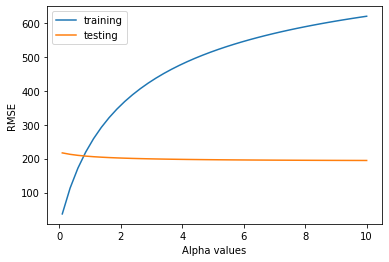

In [ ]:
plt.plot(np.linspace(0.1, 10, 40), train_rmse, label = "training")
plt.plot(np.linspace(0.1, 10, 40), test_rmse, label = "testing")
plt.xlabel("Alpha values")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [ ]:
Y_decoded, _, _ = run_decode(X_voxels[train_indxs, :], Y_imgFeats[train_indxs, :], X_voxels[test_indxs, :], Y_imgFeats[test_indxs, :], iter = 1000, alpha = 0.86)

x_train (950, 8461)
y_train (950, 4096)
x_test (50, 8461)
y_test (50, 4096)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


train: rmse 219.13295497745267
ridge: rmse: 207.52644972350728 r2: -0.09593034177384328


In [ ]:
! mkdir /content/CNS-GAN/tmp/decoded_feat

In [ ]:
savepath = os.path.join("/content/CNS-GAN/tmp/decoded_feat","decode_pred.pkl")
with open(savepath, 'wb') as f:
    pkl.dump(Y_decoded, f)

In [ ]:
keys = ["stimulus_set" for i in range(50)]
savepath = os.path.join("/content/CNS-GAN/tmp/decoded_feat","decode_id.pkl")
with open(savepath, 'wb') as f:
    pkl.dump(keys, f)

## Training dataloader

In [ ]:
! mkdir CNS-GAN/tmp/dcnn_train

In [ ]:
! python CNS-GAN/reconstruction/train_dataloader.py --dataset "/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/training_imgs" --decoded_feat CNS-GAN/tmp/decoded_feat --output CNS-GAN/tmp/dcnn_train

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
-------- loading DCNN training images ---------
-------- DCNN training data saved ---------


## Train DCNN-GAN

In [ ]:
! git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2503, done.
remote: Total 2503 (delta 0), reused 0 (delta 0), pack-reused 2503
Receiving objects: 100% (2503/2503), 8.19 MiB | 30.73 MiB/s, done.
Resolving deltas: 100% (1570/1570), done.


In [ ]:
! mv /content/pytorch-CycleGAN-and-pix2pix/ /content/pix2pix
! mv /content/pix2pix /content/CNS-GAN/reconstruction/pix2pix

In [ ]:
! pip3 install -r /content/CNS-GAN/reconstruction/pix2pix/pix2pix/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.6 MB/s 
     |████████████████████████████████| 182 kB 90.3 MB/s 
     |████████████████████████████████| 168 kB 82.7 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 168 kB 95.8 MB/s 
     |████████████████████████████████| 166 kB 97.0 MB/s 
     |████████████████████████████████| 166 kB 99.3 MB/s 
     |████████████████████████████████| 162 kB 92.6 MB/s 
     |████████████████████████████████| 162 kB 91.7 MB/s 
     |████████████████████████████████| 158 kB 94.1 MB/s 
     |████████████████████████████████| 157 kB 83.5 MB/s 
     |████████████████████████████████| 157 kB 77.4 MB/s 
     |████████████████████████████████| 157 kB 97.6 MB/s 
     |████████████████████████████████| 157 kB 97.7 MB/s 
     |████████████████████████████████| 157 kB 91.4 MB/s 
     |████████████████████████████

## Training the DCNN and pix2pix

In [ ]:
! python3 /content/CNS-GAN/reconstruction/train.py --DCNN_dataset CNS-GAN/tmp/dcnn_train --pix2pix_dataset "/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/training_imgs"

-------- loading DCNN training data --------
-------- training DCNN model --------
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")
train epoch:  0 loss 0.3882193
train epoch:  0 loss 0.06369558
train epoch:  1 loss 0.056318462
train epoch:  1 loss 0.0627575
train epoch:  2 loss 0.052576147
train epoch:  2 loss 0.055580243
train epoch:  3 loss 0.045147114
train epoch:  3 loss 0.06270105
train epoch:  4 loss 0.04591355
train epoch:  4 loss 0.05333653
train epoch:  5 loss 0.045138136
train epoch:  5 loss 0.046368543
train epoch:  6 loss 0.04460931
train epoch:  6 loss 0.0485795
train epoch:  7 loss 0.035648506
train epoch:  7 loss 0.0469022
train epoch:  8 loss 0.053526245
train epoch:  8 loss 0.050220598
train epoch:  9 loss 0.029472832
train epoch:  9 loss 0.029619077
train epoc

In [ ]:
# Copy over the loss into a txt file
dcnn_train_loss = open("/content/drive/MyDrive/Stanford PhD/First Year/Deep learning/dcnn_train_loss.txt","r+")

In [ ]:
train_loss = []
c = 0
sum_ = 0
for line in dcnn_train_loss.readlines():
  loss = float(line.split()[-1])

  c+=1
  sum_ += loss

  if c == 2:
    train_loss.append(sum_ / 2)
    c = 0
    sum_ = 0

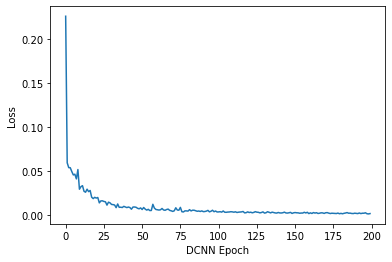

In [ ]:
plt.plot(train_loss)
plt.xlabel("DCNN Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
gan_train_loss = open("/content/CNS-GAN/reconstruction/model/checkpoints/stimulus_set/loss_log.txt","r+")

In [ ]:
G_GAN, G_L1, D_real, D_fake = [], [], [], []
epoch = '1,'
c = 0
G_GAN_sum, G_L1_sum, D_real_sum, D_fake_sum = 0, 0, 0, 0

for line in gan_train_loss.readlines()[1:]:
  c += 1

  G_GAN_sum += float(line.split()[9])
  G_L1_sum += float(line.split()[11])
  D_real_sum += float(line.split()[13])
  D_fake_sum += float(line.split()[15])

  if line.split()[1] != epoch:
    G_GAN.append(G_GAN_sum/c)
    G_L1.append(G_L1_sum/c)
    D_real.append(D_real_sum/c)
    D_fake.append(D_fake_sum/c)

    G_GAN_sum, G_L1_sum, D_real_sum, D_fake_sum = 0, 0, 0, 0
    epoch = line.split()[1]
    c = 0
    

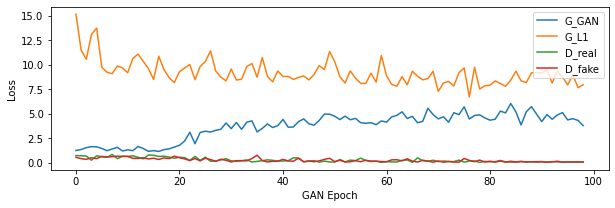

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(3)
plt.plot(G_GAN, label = "G_GAN")
plt.plot(G_L1, label = "G_L1")
plt.plot(D_real, label = "D_real")
plt.plot(D_fake, label = "D_fake")
plt.xlabel("GAN Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

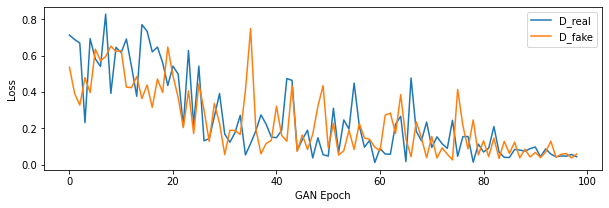

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(3)
# plt.plot(G_GAN, label = "G_GAN")
# plt.plot(G_L1, label = "G_L1")
plt.plot(D_real, label = "D_real")
plt.plot(D_fake, label = "D_fake")
plt.xlabel("GAN Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

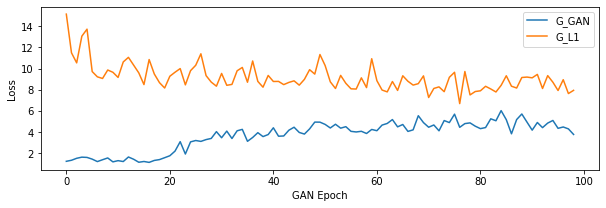

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(3)
plt.plot(G_GAN, label = "G_GAN")
plt.plot(G_L1, label = "G_L1")
# plt.plot(D_real, label = "D_real")
# plt.plot(D_fake, label = "D_fake")
plt.xlabel("GAN Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Change the path of images on test.py
! python3 /content/CNS-GAN/reconstruction/test.py --decoded_feat /content/CNS-GAN/tmp/decoded_feat --output /content/CNS-GAN/reconstruction/results

-------- loading model --------
-------- reconstruction --------
-------- generate coarse image --------
-------- reconstruction complete --------


In [ ]:
! cp -r /content/CNS-GAN/reconstruction/model "/content/drive/MyDrive/Stanford PhD/First Year/Deep learning"

## Load and test model on images

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# First have to produce the images from the reconstruction!
# /content/drive/MyDrive/Stanford PhD/First Year/Deep learning/natural_scenes_demo/testing_imgs

In [ ]:
class transnet(nn.Module):
  def __init__(self):
      super(transnet, self).__init__()
      self.fc = nn.Sequential(nn.Linear(4096, 512 * 7 * 7))
      self.layer4 = nn.Sequential(nn.ConvTranspose2d(512, 256, 4, stride = 2, padding = 1), nn.BatchNorm2d(256), nn.ReLU(True))
      self.layer3 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, stride = 2, padding = 1), nn.BatchNorm2d(128), nn.ReLU(True))
      self.layer2 = nn.Sequential(nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1), nn.BatchNorm2d(128), nn.ReLU(True))
      self.layer1 = nn.Sequential(nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1), nn.BatchNorm2d(128), nn.ReLU(True))
      self.layer0 = nn.Conv2d(128, 3, 1, stride = 1, padding = 0)
  def forward(self, input):
      x = self.fc(input)
      x = x.reshape(x.shape[0], 512, 7, 7)
      x = self.layer4(x)
      x = self.layer3(x)
      x = self.layer2(x)
      x = self.layer1(x)
      x = self.layer0(x)
      return x

In [ ]:
transNet = transnet().cuda()

In [ ]:
transNet.load_state_dict(torch.load("/content/CNS-GAN/reconstruction/model/deconvNN_par.pkl"))

<All keys matched successfully>

In [ ]:
input_fmriFeat = torch.tensor([features[stimulus_data["image_name"][1]]]).float()
output = transNet(input_fmriFeat.cuda()).cpu()
output_np = output.detach().numpy()
output_np = (output_np - np.min(output_np)) / (np.max(output_np) - np.min(output_np))
plt.imsave("trained.png", np.swapaxes(output_np[0, ...].T, 0, 1))

In [ ]:
i = 1
input_fmriFeat = torch.tensor(Y_decoded[i:i+1, :]).float()
output = transNet(input_fmriFeat.cuda()).cpu()
output_np = output.detach().numpy()
output_np = (output_np - np.min(output_np)) / (np.max(output_np) - np.min(output_np))
plt.imsave("test.png", np.swapaxes(output_np[0, ...].T, 0, 1))

## Move images to correct folder

In [ ]:
%cd "/content/drive/MyDrive/Classes/First Year/CS 230/natural_scenes_demo/imgs_scratch/stimulus_set" 

/content/drive/MyDrive/Classes/First Year/CS 230/natural_scenes_demo/training_imgs/stimulus_set


In [ ]:
import os
import shutil

In [ ]:
src_pth = "/content/drive/MyDrive/Classes/First Year/CS 230/natural_scenes_demo/imgs_scratch/stimulus_set/"
des_pth = "/content/drive/MyDrive/Classes/First Year/CS 230/natural_scenes_demo/training_imgs/stimulus_set/"

In [ ]:
for fn in os.listdir():
  if fn[:2] != "._":
    shutil.move(src_pth + fn, des_pth + fn)

In [ ]:
%cd "/content"

/content
